## Show and Tell: A Neural Image Caption Generator

[Show and Tell: A Neural Image Caption Generator](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Vinyals_Show_and_Tell_2015_CVPR_paper.pdf)

- Train on [Flickr8k](https://www.kaggle.com/ming666/flicker8k-dataset) dataset.
- Implemented on Tensorflow Keras

In [130]:
import numpy as np # linear algebra
import os # accessing directory structure
import pickle

import matplotlib.pyplot as plt # plotting
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from PIL import Image
from tqdm import tqdm

There is 0 csv file in the current version of the dataset:


In [131]:
print("Dataset {}".format(os.listdir('../input'))) # Flickr dataset
#print("Image feature cache {}".format(os.listdir('/kaggle/working'))) # Image cache directory
print("Tensorflow version {}".format(tf.__version__))

Dataset ['Flickr8k_Dataset', 'flickr8k_text', 'Flickr8k_text', 'flickr8k_dataset']
Tensorflow version 2.1.0-rc0


## Load image captions data
- flickr8k_text/Flickr8k.token.txt

In [132]:
all_captions = []
all_img_name_vector = []

with open('../input/flickr8k_text/Flickr8k.token.txt', 'r') as f:
    for line in f.readlines():
        arr = line.split('.')
        img_name = arr[0]
        text = arr[1]
        
        caption_token_arr = text.split()[1:]
        caption = ' '.join(caption_token_arr)
        caption = '<start> ' + caption + ' <end>'
        all_img_name_vector.append(img_name)
        all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state=1)

## Utility functions for images

In [133]:
def show_img(img_name, caption):
    img_path = '../input/flickr8k_dataset/Flicker8k_Dataset/{}.jpg'.format(img_name)
    img = np.array(Image.open(img_path))
    plt.title(caption)
    plt.imshow(img)

def get_image_path(image_name):
    return '../input/flickr8k_dataset/Flicker8k_Dataset/{}.jpg'.format(image_name)

def get_feature_path(image_name):
    return "/kaggle/working/{}".format(image_name)

def extract_image_name(image_path):
    image_name = image_path.split('/')[-1]
    image_name = image_name.split(".")[0] # without .jpg suffix
    return image_name

## Show an image/caption example

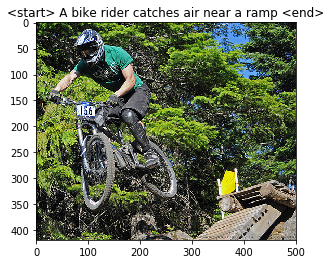

In [134]:
num_examples = 6000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

show_img(img_name_vector[1], train_captions[1])

## Using pretrained InceptionV3 model

In [135]:
image_model = tf.keras.applications.InceptionV3(weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.get_layer('avg_pool').output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 149, 149, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 149, 149, 32) 0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

## Caching image features
- save image features into disk to avoid memory overflow.

In [136]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [137]:
encode_train = sorted(set(img_name_vector))
encode_train = list(map(get_image_path, encode_train))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

for img, path in image_dataset:
    # img shape (299, 299,3)
    features = tf.expand_dims(img, axis=0)  # shape (1, 299, 299, 3)
    features = image_features_extract_model.predict(features) # shape (1, 2048)
    image_name = extract_image_name(path.numpy().decode("utf-8"))
    path_of_feature = get_feature_path(image_name)
    np.save(path_of_feature, features) # cache image features
        

In [138]:
os.listdir('/kaggle/working')

['3638908276_b1751d30ff.npy',
 '2692635048_16c279ff9e.npy',
 '3237760601_5334f3f3b5.npy',
 '2472250097_a3191a94b3.npy',
 '1511807116_41c3645e8c.npy',
 '2165461920_1a4144eb2b.npy',
 '1904112245_549e47c8aa.npy',
 '2632366677_43dee456a5.npy',
 '1808370027_2088394eb4.npy',
 '3231237864_8cb1c6d863.npy',
 '3520321387_710ab74cda.npy',
 '827941668_2e4ac6cb39.npy',
 '1523984678_edd68464da.npy',
 '2500567791_101d5ddee3.npy',
 '3672105509_53b13b2ed4.npy',
 '3076052114_233f42ae5b.npy',
 '3587449716_3bf1552c36.npy',
 '3260214530_7179346407.npy',
 '295729735_8360f2e64c.npy',
 '3379839396_0cd84b55f1.npy',
 '2805822564_6dee48e506.npy',
 '1490670858_e122df2560.npy',
 '3681575323_433d007650.npy',
 '3300679815_2c6c2301cb.npy',
 '2831672255_d779807c14.npy',
 '462080147_ca088e6541.npy',
 '3644941648_012ec87848.npy',
 '3197482764_2f289cb726.npy',
 '3690348036_a01f243fb0.npy',
 '241345942_ea76966542.npy',
 '3143765063_a7761b16d3.npy',
 '2277299634_e14bdb7ff7.npy',
 '2898304260_a4099a193a.npy',
 '2455528149_6

## Caption text preprocessing
- tokenize each caption text
- encode each caption into vector/sequence whose lenght is equal to maximum length of any caption in our dataset.
- add text paddings

In [139]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [140]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
max_length = calc_max_length(train_seqs)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=max_length, padding='post')
print(cap_vector)

[[   3    2  396 ...    0    0    0]
 [   3    2   84 ...    0    0    0]
 [   3    2   18 ...    0    0    0]
 ...
 [   3    2   12 ...    0    0    0]
 [   3    2 1424 ...    0    0    0]
 [   3  282   94 ...    0    0    0]]


## Split the data into training and testing

In [141]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(4800, 4800, 1200, 1200)

In [166]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train)
features_shape = 2048
print("vocabulary size {}".format(vocab_size))

vocabulary size 3732


- load image features

In [143]:
def map_func(img_name, cap):
    path_of_feature = get_feature_path(img_name.decode('utf-8'))
    img_tensor = np.load(path_of_feature+'.npy')
    return img_tensor, cap

### Training dataset

In [144]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Validation dataset

In [145]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## NIC Model

In [209]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        self.lstm = tf.keras.layers.LSTM(self.units, 
                                         return_sequences=True,
                                         return_state=True)
        
        self.fc1 = tf.keras.layers.Dense(self.units)
        #self.dropout = tf.keras.layers.Dropout(0.2)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x, s_a, s_c):
        x = self.embedding(x)
        
        x, a, c = self.lstm(x, [s_a, s_c])
        
        x = self.fc1(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        return x, a, c
    

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## Training

In [210]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask

    return tf.reduce_mean(loss_)

def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_states()

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        ## first pass image features to lstm
        features = encoder(img_tensor)
        _, a, c = decoder.lstm(features)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, a, c = decoder(dec_input, a, c)

            loss += loss_function(target[:, i], predictions)
            # passing targets to next timestep
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

def validation_step(img_tensor, target):
    loss = 0
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    hidden = decoder.reset_states()
    
    features = encoder(img_tensor)
    _, a, c = decoder.lstm(features)
    
    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, a, c = decoder(dec_input, a, c)
        
        loss += loss_function(target[:, i], predictions)
        predicted_id = tf.random.categorical(tf.squeeze(predictions,1), predictions.shape[0])[0].numpy()
        # passing predictited target to next timestep
        dec_input = tf.expand_dims(predicted_id, 1)

    total_loss = (loss / int(target.shape[1]))
    
    return loss, total_loss

In [212]:
EPOCHS = 20
loss_plot = []
val_loss_plot = []
val_num_steps = len(img_name_val)

for epoch in range(0, EPOCHS):
    total_loss = 0
    v_total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    
    for (batch, (val_img_tensor, val_target)) in enumerate(val_dataset):
        v_batch_loss, v_loss = validation_step(val_img_tensor, val_target)
        v_total_loss += v_loss
    
    loss_plot.append(total_loss / num_steps)
    val_loss_plot.append( v_total_loss / val_num_steps)
    
    print ('Epoch {} Traing Loss {:.6f} Validation Loss {:.6f}'.format(epoch + 1,total_loss/num_steps,
                                         v_total_loss/val_num_steps))

Epoch 1 Traing Loss 0.022455 Validation Loss 0.058530
Epoch 2 Traing Loss 0.021174 Validation Loss 0.064002
Epoch 3 Traing Loss 0.020033 Validation Loss 0.069199
Epoch 4 Traing Loss 0.019100 Validation Loss 0.067537
Epoch 5 Traing Loss 0.018264 Validation Loss 0.068130
Epoch 6 Traing Loss 0.017460 Validation Loss 0.068497
Epoch 7 Traing Loss 0.016655 Validation Loss 0.073538
Epoch 8 Traing Loss 0.015866 Validation Loss 0.073358
Epoch 9 Traing Loss 0.015067 Validation Loss 0.074289
Epoch 10 Traing Loss 0.014282 Validation Loss 0.076360
Epoch 11 Traing Loss 0.013485 Validation Loss 0.075715
Epoch 12 Traing Loss 0.012722 Validation Loss 0.078332
Epoch 13 Traing Loss 0.011994 Validation Loss 0.082200
Epoch 14 Traing Loss 0.011223 Validation Loss 0.083328
Epoch 15 Traing Loss 0.010524 Validation Loss 0.084101
Epoch 16 Traing Loss 0.009753 Validation Loss 0.087501
Epoch 17 Traing Loss 0.009051 Validation Loss 0.089820
Epoch 18 Traing Loss 0.008309 Validation Loss 0.096914
Epoch 19 Traing Los

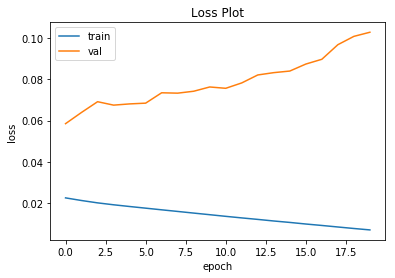

In [213]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.title('Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [184]:
def evaluate_image(img_name):
    path_of_feature = get_feature_path(img_name)
    img_tensor = np.load(path_of_feature+'.npy')
    hidden = decoder.reset_states()
    
    features = encoder(img_tensor)
    features = tf.expand_dims(features, 0)
    
    _, a, c = decoder.lstm(features)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    result = []
    for i in range(max_length):
        predictions, a, c = decoder(dec_input, a, c)
        #print("predictions shape {}".format(predictions.shape))
        predictions = tf.squeeze(predictions, axis=0)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        if tokenizer.index_word[predicted_id] == '<end>':
            break
            
        result.append(tokenizer.index_word[predicted_id])

        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result

565605894_8f0bed0438


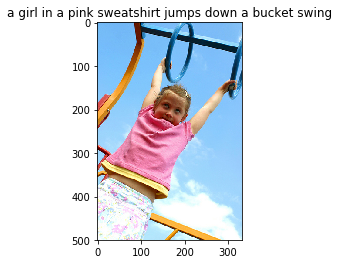

In [247]:
rid = np.random.randint(0, len(img_name_val))
img_name = img_name_val[rid]
print(img_name)
result = evaluate_image(img_name)
#print(result)
show_img(img_name, ' '.join(result))

3726168984_1fa2c8965b


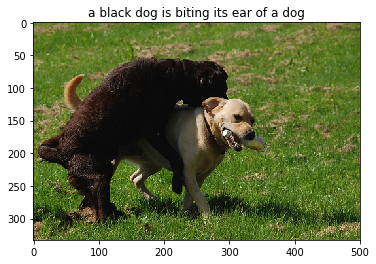

In [208]:
rid = np.random.randint(0, len(img_name_val))
img_name = img_name_val[rid]
print(img_name)
result = evaluate_image(img_name)
#print(result)
show_img(img_name, ' '.join(result))

143688895_e837c3bc76


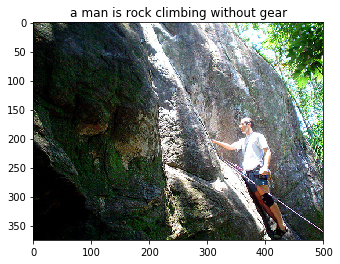

In [222]:
rid = np.random.randint(0, len(img_name_val))
img_name = img_name_val[rid]
print(img_name)
result = evaluate_image(img_name)
#print(result)
show_img(img_name, ' '.join(result))

445861800_75fc6a8c16


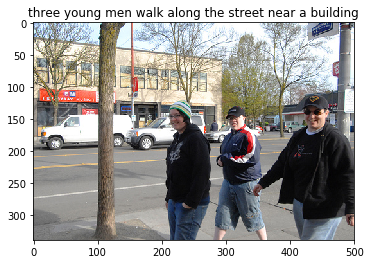

In [243]:
rid = np.random.randint(0, len(img_name_val))
img_name = img_name_val[rid]
print(img_name)
result = evaluate_image(img_name)
#print(result)
show_img(img_name, ' '.join(result))

In [ ]:
rid = np.random.randint(0, len(img_name_val))
img_name = img_name_val[rid]
print(img_name)
result = evaluate_image(img_name)
#print(result)
show_img(img_name, ' '.join(result))